# H1-B Status Prediction
### Data Source:  https://www.kaggle.com/nsharan/h-1b-visa

In [80]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('H1B').getOrCreate()

In [3]:
df = spark.read.csv('h1b_kaggle.csv',inferSchema=True,header=True)

In [5]:
df.show(5)

+---+-------------------+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+-----------+----------+
|_c0|        CASE_STATUS|       EMPLOYER_NAME|            SOC_NAME|           JOB_TITLE|FULL_TIME_POSITION|PREVAILING_WAGE|YEAR|            WORKSITE|        lon|       lat|
+---+-------------------+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+-----------+----------+
|  1|CERTIFIED-WITHDRAWN|UNIVERSITY OF MIC...|BIOCHEMISTS AND B...|POSTDOCTORAL RESE...|                 N|          36067|2016| ANN ARBOR, MICHIGAN|-83.7430378|42.2808256|
|  2|CERTIFIED-WITHDRAWN|GOODMAN NETWORKS,...|    CHIEF EXECUTIVES|CHIEF OPERATING O...|                 Y|         242674|2016|        PLANO, TEXAS|-96.6988856|33.0198431|
|  3|CERTIFIED-WITHDRAWN|PORTS AMERICA GRO...|    CHIEF EXECUTIVES|CHIEF PROCESS OFF...|                 Y|         193066|2016|JERSEY 

In [6]:
df.dtypes

[('_c0', 'int'),
 ('CASE_STATUS', 'string'),
 ('EMPLOYER_NAME', 'string'),
 ('SOC_NAME', 'string'),
 ('JOB_TITLE', 'string'),
 ('FULL_TIME_POSITION', 'string'),
 ('PREVAILING_WAGE', 'string'),
 ('YEAR', 'string'),
 ('WORKSITE', 'string'),
 ('lon', 'string'),
 ('lat', 'string')]

In [7]:
df.count()

3002458

In [158]:
df.groupby('CASE_STATUS').count().show()

+--------------------+-------+
|         CASE_STATUS|  count|
+--------------------+-------+
|                  NA|     13|
|           CERTIFIED|2615623|
| CERTIFIED-WITHDRAWN| 202659|
|         INVALIDATED|      1|
|PENDING QUALITY A...|     15|
|            REJECTED|      2|
|           WITHDRAWN|  89799|
|              DENIED|  94346|
+--------------------+-------+



### Drop Duplicates

In [8]:
df=df.drop_duplicates()

In [9]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).toPandas()

,_c0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,0,0,0,0,0,0,0,0,0,0,7


In [11]:
df=df.sample(0.001,seed=100)

In [12]:
df.count()

2977

In [152]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).toPandas()

,_c0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
dfp=df.toPandas()

In [14]:
dfp.head()

,_c0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,274023,CERTIFIED,"IVS CONSULTING,INC",COMPUTER PROGRAMMERS,COMPUTER PROGRAMMER,N,56638,2016,"RARITAN, NEW JERSEY",-74.6329363,40.5695474
1,89878,WITHDRAWN,E-DATA EXPERTS INC,COMPUTER SYSTEMS ANALYSTS,COMPUTER SYSTEMS ANALYST,Y,77147,2016,"PLEASANTON, CALIFORNIA",-121.8746789,37.6624312
2,571969,CERTIFIED,"BERKELEY LIGHTS, INC.",BIOCHEMISTS AND BIOPHYSICISTS,SINGLE CELL GENOMICS SCIENTIST,Y,104624,2016,"EMERYVILLE, CALIFORNIA",-122.2852473,37.831316
3,936663,CERTIFIED,"LGBS SOFTWARE, INC.",COMPUTER PROGRAMMERS,PROGRAMMER / ANALYST,Y,50294,2015,"ENCINITAS, CALIFORNIA",-117.2919818,33.0369867
4,992918,CERTIFIED,MR INFO TECH LLC.,COMPUTER PROGRAMMERS,PROGRAMMER ANALYST,Y,55370,2015,"ALPHARETTA, GEORGIA",-84.2940899,34.0753762


In [15]:
dfp.YEAR.value_counts()

2016    663
2015    616
2014    489
2013    445
2012    394
2011    370
Name: YEAR, dtype: int64

In [16]:
df.crosstab('CASE_STATUS','YEAR').toPandas()

,CASE_STATUS_YEAR,2011,2012,2013,2014,2015,2016
0,CERTIFIED-WITHDRAWN,5,23,52,45,41,46
1,DENIED,37,24,12,13,10,11
2,CERTIFIED,320,338,371,421,548,592
3,WITHDRAWN,8,9,10,10,17,14


In [17]:
df.createOrReplaceTempView("df")

In [18]:
df=spark.sql("select * from df where YEAR not in ('54538')")

In [19]:
df.crosstab('CASE_STATUS','YEAR').toPandas()

,CASE_STATUS_YEAR,2011,2012,2013,2014,2015,2016
0,CERTIFIED-WITHDRAWN,5,23,52,45,41,46
1,DENIED,37,24,12,13,10,11
2,CERTIFIED,320,338,371,421,548,592
3,WITHDRAWN,8,9,10,10,17,14


In [20]:
#dfp.plot(x='YEAR',kind='bar')

In [21]:
dfp.CASE_STATUS.value_counts()

CERTIFIED              2590
CERTIFIED-WITHDRAWN     212
DENIED                  107
WITHDRAWN                68
Name: CASE_STATUS, dtype: int64

In [153]:
dfp.isnull().sum()

_c0                   0
CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
lon                   0
lat                   0
dtype: int64

------------------------------------------------------------------------------------------------------------------------------

##### Data pre-processing

In [23]:
data=df

In [24]:
data.show()

+-------+-------------------+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+------------+----------+
|    _c0|        CASE_STATUS|       EMPLOYER_NAME|            SOC_NAME|           JOB_TITLE|FULL_TIME_POSITION|PREVAILING_WAGE|YEAR|            WORKSITE|         lon|       lat|
+-------+-------------------+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+------------+----------+
| 274023|          CERTIFIED|  IVS CONSULTING,INC|COMPUTER PROGRAMMERS| COMPUTER PROGRAMMER|                 N|          56638|2016| RARITAN, NEW JERSEY| -74.6329363|40.5695474|
|  89878|          WITHDRAWN|  E-DATA EXPERTS INC|COMPUTER SYSTEMS ...|COMPUTER SYSTEMS ...|                 Y|          77147|2016|PLEASANTON, CALIF...|-121.8746789|37.6624312|
| 571969|          CERTIFIED|BERKELEY LIGHTS, ...|BIOCHEMISTS AND B...|SINGLE CELL GENOM...|                 Y

### Convert to binary with only certified and denied

In [28]:
dfp.columns

Index(['_c0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'lon',
       'lat'],
      dtype='object')

In [29]:
df_updated=spark.sql("select CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,case when CASE_STATUS IN ('INVALIDATED','PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED','REJECTED','DENIED','CERTIFIED-WITHDRAWN','WITHDRAWN','NA') then '0' else '1' end as UPDATED_CASE_STATUS from df")

In [118]:
df_updated.groupby('YEAR').count().show()

+----+-----+
|YEAR|count|
+----+-----+
|2016|  663|
|2012|  394|
|2014|  489|
|2013|  445|
|2011|  370|
|2015|  616|
+----+-----+



In [31]:
df_updated=df_updated.drop('CASE_STATUS')

In [32]:
df_updated.show(5)

+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+-------------------+
|       EMPLOYER_NAME|            SOC_NAME|           JOB_TITLE|FULL_TIME_POSITION|PREVAILING_WAGE|YEAR|            WORKSITE|UPDATED_CASE_STATUS|
+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+-------------------+
|  IVS CONSULTING,INC|COMPUTER PROGRAMMERS| COMPUTER PROGRAMMER|                 N|          56638|2016| RARITAN, NEW JERSEY|                  1|
|  E-DATA EXPERTS INC|COMPUTER SYSTEMS ...|COMPUTER SYSTEMS ...|                 Y|          77147|2016|PLEASANTON, CALIF...|                  0|
|BERKELEY LIGHTS, ...|BIOCHEMISTS AND B...|SINGLE CELL GENOM...|                 Y|         104624|2016|EMERYVILLE, CALIF...|                  1|
| LGBS SOFTWARE, INC.|COMPUTER PROGRAMMERS|PROGRAMMER / ANALYST|                 Y|          50294|2015|ENCINITAS, CALIFO...

In [155]:
df_updated.groupby('UPDATED_CASE_STATUS').count().show()

+-------------------+-----+
|UPDATED_CASE_STATUS|count|
+-------------------+-----+
|                  0|  387|
|                  1| 2590|
+-------------------+-----+



### Converting final data to Pandas dataframe for further visualization

In [33]:
dfpUpdate=df_updated.toPandas()

In [34]:
dfpUpdate.head(5)

,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,UPDATED_CASE_STATUS
0,"IVS CONSULTING,INC",COMPUTER PROGRAMMERS,COMPUTER PROGRAMMER,N,56638,2016,"RARITAN, NEW JERSEY",1
1,E-DATA EXPERTS INC,COMPUTER SYSTEMS ANALYSTS,COMPUTER SYSTEMS ANALYST,Y,77147,2016,"PLEASANTON, CALIFORNIA",0
2,"BERKELEY LIGHTS, INC.",BIOCHEMISTS AND BIOPHYSICISTS,SINGLE CELL GENOMICS SCIENTIST,Y,104624,2016,"EMERYVILLE, CALIFORNIA",1
3,"LGBS SOFTWARE, INC.",COMPUTER PROGRAMMERS,PROGRAMMER / ANALYST,Y,50294,2015,"ENCINITAS, CALIFORNIA",1
4,MR INFO TECH LLC.,COMPUTER PROGRAMMERS,PROGRAMMER ANALYST,Y,55370,2015,"ALPHARETTA, GEORGIA",1


### Visualizing the Data

In [119]:
yeardist=df_updated.crosstab('YEAR','UPDATED_CASE_STATUS').toPandas()

In [128]:
job=df_updated.crosstab('JOB_TITLE','UPDATED_CASE_STATUS').toPandas()

In [120]:
yeardist

,YEAR_UPDATED_CASE_STATUS,0,1
0,2014,68,421
1,2013,74,371
2,2015,68,548
3,2011,50,320
4,2012,56,338
5,2016,71,592


In [122]:
yeardist=yeardist.sort_values(by=['YEAR_UPDATED_CASE_STATUS'])

In [123]:
yeardist

,YEAR_UPDATED_CASE_STATUS,0,1
3,2011,50,320
4,2012,56,338
1,2013,74,371
0,2014,68,421
2,2015,68,548
5,2016,71,592


In [134]:
job=job.sort_values(by=['1'],ascending=False).head(10)
job

,JOB_TITLE_UPDATED_CASE_STATUS,0,1
349,PROGRAMMER ANALYST,22,213
228,SOFTWARE ENGINEER,24,101
269,COMPUTER PROGRAMMER,10,67
783,SYSTEMS ANALYST,7,58
52,SOFTWARE DEVELOPER,6,38
350,BUSINESS ANALYST,3,35
1003,COMPUTER SYSTEMS ANALYST,8,33
824,TECHNOLOGY LEAD - US,0,29
930,CONSULTANT,0,27
950,SENIOR CONSULTANT,3,25


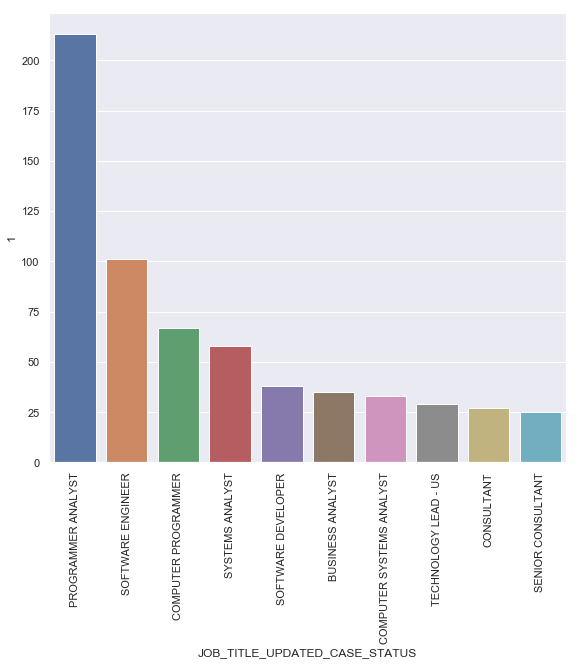

In [151]:
import seaborn as sns
ax=sns.barplot(data=job,x='JOB_TITLE_UPDATED_CASE_STATUS',y='1')
rc={'figure.figsize':(9.27,8.27)}
sns.set(rc)
ax.set_xticklabels(labels=job['JOB_TITLE_UPDATED_CASE_STATUS'],rotation=90)
display(ax)

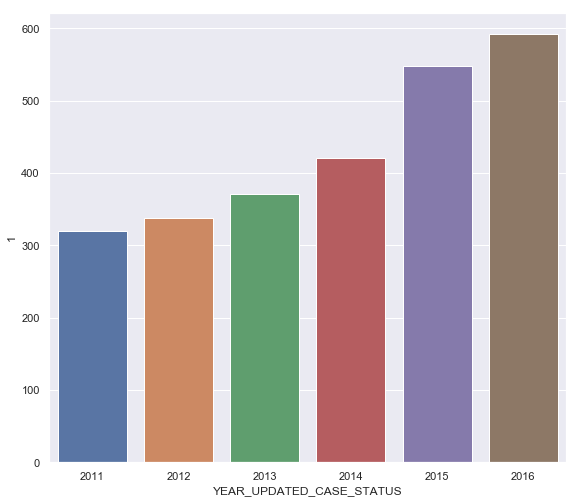

In [125]:
import seaborn as sns
ax=sns.barplot(data=yeardist,x='YEAR_UPDATED_CASE_STATUS',y='1')
rc={'figure.figsize':(9.27,8.27)}
sns.set(rc)
display(ax)

In [126]:
dfp_updated=df_updated.toPandas()
employer=dfp_updated[dfp_updated['UPDATED_CASE_STATUS']=='1'].EMPLOYER_NAME.value_counts()

In [147]:
employer.head()

INFOSYS LIMITED                      121
TATA CONSULTANCY SERVICES LIMITED     64
WIPRO LIMITED                         54
DELOITTE CONSULTING LLP               35
IBM INDIA PRIVATE LIMITED             26
Name: EMPLOYER_NAME, dtype: int64

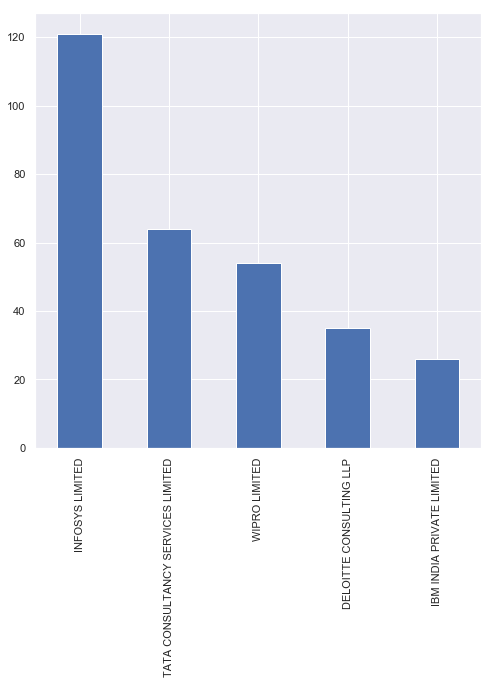

In [127]:
ax=employer.head().plot.bar(x=employer.index,y=employer.values,figsize=(8,8))
display(ax)

### Create a 80-20 train test split

In [36]:
train_data,test_data=df_updated.randomSplit([0.8,0.2])

------------------------------------------------------------------------------------------------------------------------------

### Building the Logistic RegressionClassifier

In [37]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoderEstimator
from pyspark.ml import Pipeline

In [38]:
df_updated.dtypes

[('EMPLOYER_NAME', 'string'),
 ('SOC_NAME', 'string'),
 ('JOB_TITLE', 'string'),
 ('FULL_TIME_POSITION', 'string'),
 ('PREVAILING_WAGE', 'string'),
 ('YEAR', 'string'),
 ('WORKSITE', 'string'),
 ('UPDATED_CASE_STATUS', 'string')]

In [39]:
# Use StringIndexer to convert the categorical columns to hold numerical data

employer_name_indexer = StringIndexer(inputCol='EMPLOYER_NAME',outputCol='EMPLOYER_NAME_index',handleInvalid='keep')
soc_name_indexer = StringIndexer(inputCol='SOC_NAME',outputCol='SOC_NAME_index',handleInvalid='keep')
job_title_indexer = StringIndexer(inputCol='JOB_TITLE',outputCol='JOB_TITLE_index',handleInvalid='keep')
full_time_position_indexer = StringIndexer(inputCol='FULL_TIME_POSITION',outputCol='FULL_TIME_POSITION_index',handleInvalid='keep')
prevailing_wage_indexer = StringIndexer(inputCol='PREVAILING_WAGE',outputCol='PREVAILING_WAGE_index',handleInvalid='keep')
updated_case_status_indexer = StringIndexer(inputCol='UPDATED_CASE_STATUS',outputCol='UPDATED_CASE_STATUS_index',handleInvalid='keep')
worksite_indexer = StringIndexer(inputCol='WORKSITE',outputCol='WORKSITE_index',handleInvalid='keep')

In [40]:
data_encoder = OneHotEncoderEstimator(inputCols=['EMPLOYER_NAME_index','SOC_NAME_index','JOB_TITLE_index',
                                                 'FULL_TIME_POSITION_index','PREVAILING_WAGE_index','WORKSITE_index'],
                                      outputCols=['EMPLOYER_NAME_vec','SOC_NAME_vec','JOB_TITLE_vec','FULL_TIME_POSITION_vec',
                                                  'PREVAILING_WAGE_vec','WORKSITE_vec'],
                                      handleInvalid='keep')

In [41]:
# Vector assembler is used to create a vector of input features

assembler = VectorAssembler(inputCols=['EMPLOYER_NAME_vec','SOC_NAME_vec','JOB_TITLE_vec','FULL_TIME_POSITION_vec',
                                                  'PREVAILING_WAGE_vec','WORKSITE_vec'],outputCol="features")


In [42]:
lr_model = LogisticRegression(labelCol='UPDATED_CASE_STATUS_index')

In [43]:
pipe = Pipeline(stages=[employer_name_indexer,soc_name_indexer,job_title_indexer,full_time_position_indexer,prevailing_wage_indexer,worksite_indexer,updated_case_status_indexer,data_encoder,assembler,lr_model])


In [45]:
fit_model=pipe.fit(train_data)

In [46]:
results = fit_model.transform(test_data)

In [48]:
results.show(5)

+--------------------+--------------------+--------------------+------------------+---------------+----+--------------------+-------------------+-------------------+--------------+---------------+------------------------+---------------------+--------------+-------------------------+----------------+-----------------+-------------------+----------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------+
|       EMPLOYER_NAME|            SOC_NAME|           JOB_TITLE|FULL_TIME_POSITION|PREVAILING_WAGE|YEAR|            WORKSITE|UPDATED_CASE_STATUS|EMPLOYER_NAME_index|SOC_NAME_index|JOB_TITLE_index|FULL_TIME_POSITION_index|PREVAILING_WAGE_index|WORKSITE_index|UPDATED_CASE_STATUS_index|    SOC_NAME_vec|     WORKSITE_vec|PREVAILING_WAGE_vec|FULL_TIME_POSITION_vec|  EMPLOYER_NAME_vec|      JOB_TITLE_vec|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+---

In [49]:
results.select(['UPDATED_CASE_STATUS_index','prediction']).show(200)

+-------------------------+----------+
|UPDATED_CASE_STATUS_index|prediction|
+-------------------------+----------+
|                      0.0|       0.0|
|                      1.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      1.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      1.0|       0.0|
|                      0.0|       0.0|
|                      1.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      0.0|       0.0|
|                      1.0|       1.0|
|                      0.

### Evaluating the model

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [60]:
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="UPDATED_CASE_STATUS_index", predictionCol="prediction", metricName="accuracy")

In [61]:
accuracy = ACC_evaluator.evaluate(results)

In [62]:
print("The accuracy of the logistic regression classifier is {}".format(accuracy))

The accuracy of the decision tree classifier is 0.8344155844155844


In [166]:
from sklearn.metrics import recall_score,precision_score

#### Precision= TP/(TP+FP) Total Predicted Positive
#### Recall= TP/(TP+FN) Total Actual Positive

In [167]:
precision = precision_score(y_true, y_pred)
print("The precision of the logistic regression classifier is {}".format(precision))

0.3548387096774194

In [169]:
recall = recall_score(y_true, y_pred)
print("The recall of the logistic regression classifier is {}".format(recall))

The recall of the logistic regression classifier is 0.11827956989247312


In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
y_true = results.select("UPDATED_CASE_STATUS_index")
y_true = y_true.toPandas()

y_pred = results.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix \n {}".format(cnf_matrix))

Below is the confusion matrix 
 [[503  20]
 [ 82  11]]
